# GAN creation

In [1]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
! pip install matplotlib
! pip install Pillow imageio
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip 140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import time
import pickle

In [2]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [3]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15494449090751229823
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4429836495068102407
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# Config
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100
num_images = 25000

## Dataset loading

In [ ]:
input_directory = 'real_vs_fake/real-vs-fake/train'

real_folder = os.path.join(input_directory, 'fake')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
def display_imgs(dataset, num_images=1):
    for batch in dataset.take(1):
        batch = (batch + 1) / 2
        for i in range(min(BATCH_SIZE, num_images)):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(batch[i].numpy())
            plt.axis("off")
        plt.show()

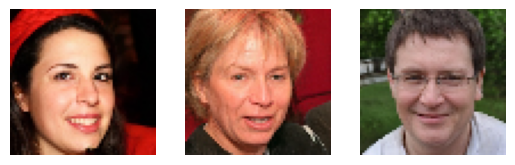

In [ ]:
display_imgs(dataset,num_images=3)

In [ ]:
len(dataset)

98

## GAN architecture

In [ ]:
# from keras.initializers import RandomNormal
# from keras.models import Sequential
# from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [ ]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(2*2*512, input_dim=latent_features, kernel_initializer=init))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((2,2,512)))

    model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init, use_bias=False))

    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        2097152   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        524288    
 ranspose)                                              

2024-04-02 13:36:19.678882: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-02 13:36:20.667029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-04-02 13:36:22.319544: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-02 13:36:22.319588: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-04-02 13:36:22.319733: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


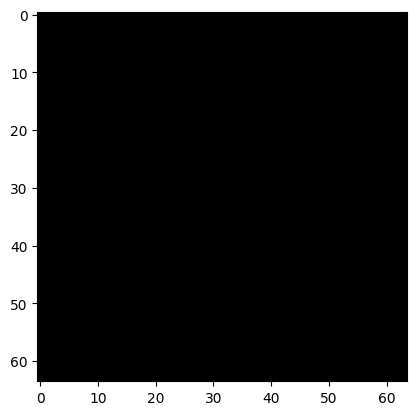

In [ ]:
img = generator(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [ ]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(32, 4, 2, padding='same',
                     input_shape = (image_width,image_height,3),
                     kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, 2, 1, kernel_initializer=init,
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1536      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32768     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

1/1 [==============================] - 0s 136ms/step


array([[0.50000554],
       [0.50000465],
       [0.50000435],
       [0.5000051 ]], dtype=float32)

## Training loop

In [ ]:
# from keras.models import load_model
# generator = load_model('models/generator.h5')
# discriminator = load_model('models/discriminator.h5')

In [ ]:
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.losses import BinaryCrossentropy
# from keras.utils import array_to_img
# from keras.callbacks import Callback

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.ones_like(ypred_real)
            # noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            # y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)
        # dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        # self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            # noise_fake = 0.10*tf.random.uniform(tf.shape(ypred_fake))
            # y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        # return {"d_loss":total_d_loss, "g_loss":total_g_loss}
        return {"d_loss":total_d_loss,"d_loss_real":real_d_loss,"d_loss_fake":fake_d_loss, "g_loss":total_g_loss}

In [ ]:
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("training/", exist_ok=True)
            img.save(f'training/{epoch}_generated_img.png')
            os.makedirs("models/", exist_ok=True)
            generator.save('models/generator.keras',include_optimizer=True)
            discriminator.save('models/discriminator.keras',include_optimizer=True)


## Training

In [ ]:
hist = gan.fit(dataset, epochs=500, callbacks=[ModelMonitor()])

Epoch 1/500
98/98 [==============================] - 6s 41ms/step - d_loss: 0.7546 - d_loss_real: 0.0396 - d_loss_fake: 0.7150 - g_loss: 0.6971
Epoch 2/500
98/98 [==============================] - 4s 40ms/step - d_loss: 0.7423 - d_loss_real: 0.0250 - d_loss_fake: 0.7173 - g_loss: 0.7123
Epoch 3/500
98/98 [==============================] - 4s 40ms/step - d_loss: 0.7130 - d_loss_real: 0.0161 - d_loss_fake: 0.6970 - g_loss: 0.7200
Epoch 4/500
98/98 [==============================] - 4s 40ms/step - d_loss: 0.7049 - d_loss_real: 0.0185 - d_loss_fake: 0.6864 - g_loss: 0.7323
Epoch 5/500
98/98 [==============================] - 4s 40ms/step - d_loss: 0.6973 - d_loss_real: 0.0165 - d_loss_fake: 0.6809 - g_loss: 0.7376
Epoch 6/500
98/98 [==============================] - 4s 41ms/step - d_loss: 0.6727 - d_loss_real: 0.0129 - d_loss_fake: 0.6597 - g_loss: 0.7558
Epoch 7/500
98/98 [==============================] - 4s 40ms/step - d_loss: 0.6667 - d_loss_real: 0.0125 - d_loss_fake: 0.6542 - g_loss:

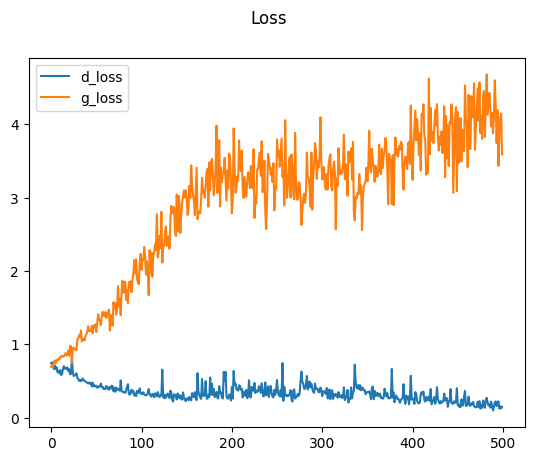

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
# plt.plot(hist.history['d_loss_real'], label='d_loss_real')
# plt.plot(hist.history['d_loss_fake'], label='d_loss_fake')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
# Function to convert images to GIF
def convert_images_to_gif(input_folder, output_gif_path):
    images = []
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Save images as GIF
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=200, loop=1)

# Example usage
input_folder = "training/"
output_gif_path = "training.gif"

convert_images_to_gif(input_folder, output_gif_path)

1/1 [==============================] - 0s 22ms/step


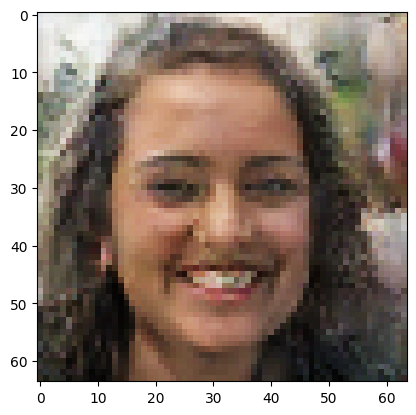

In [ ]:
img = generator.predict(tf.random.normal((1, latent_features, 1)))
img = (img + 1) / 2
plt.imshow(img[0])

In [ ]:
with open("GAN_history", 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

## Testing

In [ ]:
from keras.models import load_model
generator = load_model("models/generator.keras")
discriminator = load_model("models/discriminator.keras")

generator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])
discriminator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# For real images
for batch in dataset.take(1):
    print(discriminator.predict(batch, verbose=0))

[[0.99939847]
 [0.99999857]
 [1.        ]
 [0.97647756]
 [0.85115194]
 [0.99985087]
 [0.97602147]
 [0.99998784]
 [0.997837  ]
 [0.99999964]
 [0.99997187]
 [0.9350079 ]
 [0.99997807]
 [0.99999976]
 [0.9998735 ]
 [0.9999949 ]
 [0.8936365 ]
 [0.9999317 ]
 [0.9692705 ]
 [0.9960259 ]
 [0.9999466 ]
 [0.9993766 ]
 [0.6592321 ]
 [0.99997795]
 [0.9995414 ]
 [1.        ]
 [0.5925448 ]
 [0.9988199 ]
 [1.        ]
 [0.09049401]
 [0.93340224]
 [0.99998426]
 [0.9315506 ]
 [0.99915886]
 [0.9972045 ]
 [0.9999999 ]
 [0.9970969 ]
 [0.99996865]
 [0.98163456]
 [0.9999558 ]
 [0.99983525]
 [0.9996308 ]
 [0.99824667]
 [0.94636226]
 [0.9718891 ]
 [0.99999964]
 [1.        ]
 [1.        ]
 [0.9183736 ]
 [0.9938782 ]
 [0.98044777]
 [0.99236697]
 [0.99999225]
 [0.9952615 ]
 [0.9995247 ]
 [0.35107917]
 [1.        ]
 [0.99997103]
 [0.897453  ]
 [0.33278272]
 [0.99980515]
 [0.9828637 ]
 [0.99989045]
 [0.8946692 ]
 [0.9999695 ]
 [0.999987  ]
 [0.99962664]
 [0.9808007 ]
 [0.9816834 ]
 [0.99998283]
 [0.9107431 ]
 [0.97

In [ ]:
# For fake images
batch = generator.predict(tf.random.normal((BATCH_SIZE, latent_features, 1)),verbose=0)
results = discriminator.predict(batch, verbose=0)
print(results)

[[0.131282  ]
 [0.08786413]
 [0.00701938]
 [0.00674767]
 [0.01118752]
 [0.05067512]
 [0.05114872]
 [0.06734961]
 [0.04413228]
 [0.03010675]
 [0.05657055]
 [0.04567359]
 [0.02943596]
 [0.03082523]
 [0.01607141]
 [0.0291972 ]
 [0.12213439]
 [0.05054322]
 [0.03255682]
 [0.04052223]
 [0.03404739]
 [0.03764012]
 [0.04101186]
 [0.01012669]
 [0.05096953]
 [0.04060895]
 [0.02559254]
 [0.11143671]
 [0.02304536]
 [0.04263497]
 [0.03190184]
 [0.03117138]
 [0.02663465]
 [0.02853461]
 [0.10715959]
 [0.04550486]
 [0.02711765]
 [0.03795513]
 [0.07432425]
 [0.02201175]
 [0.04273215]
 [0.03318071]
 [0.02801652]
 [0.02450268]
 [0.0286941 ]
 [0.02127423]
 [0.02037941]
 [0.02058841]
 [0.06677005]
 [0.06916428]
 [0.02011961]
 [0.04260839]
 [0.01764362]
 [0.0424319 ]
 [0.02166717]
 [0.0375431 ]
 [0.03882011]
 [0.03423479]
 [0.03585565]
 [0.0161848 ]
 [0.09598833]
 [0.01303615]
 [0.03636579]
 [0.02540126]
 [0.06635804]
 [0.03842977]
 [0.08425287]
 [0.02096131]
 [0.02415592]
 [0.01586838]
 [0.01134825]
 [0.01

## Discriminator testing

In [ ]:
# # Generating fake data
# def save_fake(output_dir,num_images=1000):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     generated_images = generator.predict(tf.random.normal((num_images, latent_features, 1)),verbose=0)

#     for i in range(num_images):
#         image = generated_images[i]
#         image = (image + 1) / 2
#         image_path = os.path.join(output_dir, f"{i}.jpg")
#         tf.keras.preprocessing.image.save_img(image_path, image)

#     print(f"{i + 1} images generated and saved to {output_dir}.")

# save_fake("discriminator_data/test/0",num_images=10000)

10000 images generated and saved to discriminator_data/test/0.


In [ ]:
# train_dir = "discriminator_data/train/1"
# test_dir = "discriminator_data/test/1"
# if not os.path.exists(train_dir):
#     os.makedirs(train_dir)
# if not os.path.exists(test_dir):
#     os.makedirs(test_dir)

# train_count = 4000
# test_count = 1000

# # Iterate through the batches and save images
# image_counter = 0
# for batch in dataset:
#     for image in batch:
#         if image_counter < train_count:
#             save_dir = train_dir
#         else:
#             save_dir = test_dir

#         # Save the image
#         image = (image + 1) / 2
#         image_path = os.path.join(save_dir, f"{image_counter}.jpg")
#         tf.keras.preprocessing.image.save_img(image_path, image.numpy())

#         image_counter += 1
#         if image_counter >= train_count + test_count:
#             break
#     if image_counter >= train_count + test_count:
#         break

# print(f"{train_count} images saved to {train_dir}.")
# print(f"{test_count} images saved to {test_dir}.")


In [ ]:
disc_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "discriminator_data/test",
    # "real_vs_fake/real-vs-fake/test",
    labels="inferred",
    label_mode="binary",
    # class_names=['0', '1'],
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 20000 files belonging to 2 classes.


In [ ]:
def augument(x, y):
    img = tf.cast(x, tf.float32)
    img = (img - 127.5) / 127.5
    return img, y

In [ ]:
disc_test_dataset = disc_test_dataset.map(augument)

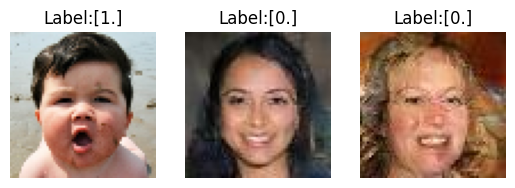

In [ ]:
for batch, labels in disc_test_dataset.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

In [ ]:
discriminator.evaluate(disc_test_dataset, verbose=0,return_dict=True)

{'loss': 0.23886162042617798, 'accuracy': 0.9139500260353088}

### Further training with styleGAN images + real images

In [10]:
from keras.models import load_model
os.makedirs("models/", exist_ok=True)
discriminator = load_model("models/discriminator.keras")
discriminator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    brightness_range=(0.5, 1.5),
    shear_range=.5,
    fill_mode="nearest",
    horizontal_flip=.5,
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
    validation_split=.5
)

validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
    validation_split=.5
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: (x - 127.5) / 127.5,
    dtype=np.float32,
)

In [12]:
train_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/train",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
    subset="training"
)

validation_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/valid",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
    subset="validation"
)

test_data = train_generator.flow_from_directory(
    "real_vs_fake/real-vs-fake/test",
    target_size=(image_height, image_width),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=69,
    interpolation="nearest",
    # keep_aspect_ratio=False,
)

Found 50000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


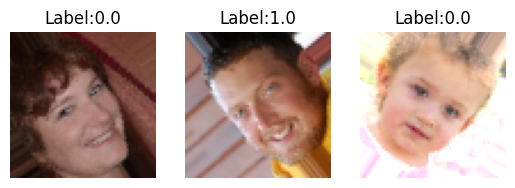

In [13]:
images, labels = train_data.next()
for i in range(3):
    plt.subplot(1,3,i+1)
    image = images[i]
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f"Label:{labels[i]}")
    plt.axis("off")
plt.show()

In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint("models/discriminator_separate_trained.keras",monitor="val_loss")

In [15]:
discriminator_history = discriminator.fit(train_data,validation_data=validation_data,callbacks=[cp_callback], epochs=10)

Epoch 1/10
196/196 [==============================] - 174s 839ms/step - loss: 0.8065 - accuracy: 0.5703 - val_loss: 0.7289 - val_accuracy: 0.5545
Epoch 2/10
196/196 [==============================] - 147s 752ms/step - loss: 0.6741 - accuracy: 0.6181 - val_loss: 0.6835 - val_accuracy: 0.5965
Epoch 3/10
196/196 [==============================] - 144s 735ms/step - loss: 0.6459 - accuracy: 0.6410 - val_loss: 0.6249 - val_accuracy: 0.6443
Epoch 4/10
196/196 [==============================] - 161s 825ms/step - loss: 0.6276 - accuracy: 0.6606 - val_loss: 0.6089 - val_accuracy: 0.6573
Epoch 5/10
196/196 [==============================] - 142s 727ms/step - loss: 0.6115 - accuracy: 0.6735 - val_loss: 0.7736 - val_accuracy: 0.5711
Epoch 6/10
196/196 [==============================] - 144s 734ms/step - loss: 0.5992 - accuracy: 0.6829 - val_loss: 0.6345 - val_accuracy: 0.6408
Epoch 7/10
196/196 [==============================] - 155s 790ms/step - loss: 0.5890 - accuracy: 0.6895 - val_loss: 0.5935 -

In [16]:
discriminator.evaluate(test_data, verbose=0,return_dict=True)

{'loss': 0.5756312608718872, 'accuracy': 0.6858999729156494}